# Lake Burdur NDWI index over the years
## Using Landsat and Sentinel Data

Sentinel
NDWI = (B03 - B08) / (B03 + B08)
Data here:
https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs

------------------------
Old Landsat
•	Band 2 - Green
•	Band 5 - Near Infrare (NIR)
Landsat 8
•	Band 3 – Green
•	Band 5 – Near Infrare (NIR)
In Landsat 4-7, NDWI = (B02 - B05) / (B02 + B05)
In Landsat 8, NDWI = (B03 - B05) / (B03 + B05)

2013 landsat
txt
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20130707_20170503_01_T1/LC08_L1TP_179034_20130707_20170503_01_T1_ANG.txt
Large Image 
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20130707_20170503_01_T1/LC08_L1TP_179034_20130707_20170503_01_T1_thumb_large.jpg
Band 3 
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20130707_20170503_01_T1/LC08_L1TP_179034_20130707_20170503_01_T1_B3.TIF
Band 5
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20130707_20170503_01_T1/LC08_L1TP_179034_20130707_20170503_01_T1_B5.TIF


2014 landsat
Txt
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20140710_20170421_01_T1/LC08_L1TP_179034_20140710_20170421_01_T1_ANG.txt
Large Image
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20140710_20170421_01_T1/LC08_L1TP_179034_20140710_20170421_01_T1_thumb_large.jpg
Band 3
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20140710_20170421_01_T1/LC08_L1TP_179034_20140710_20170421_01_T1_B3.TIF
Band 5
https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20140710_20170421_01_T1/LC08_L1TP_179034_20140710_20170421_01_T1_B5.TIF


## Install required libraries

In [1]:
!pip install rasterio
!pip install pyproj
!pip install shapely

## import all required libraries

In [2]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio.sample
from rasterio import mask
import warnings; warnings.simplefilter('ignore')
from pathlib import Path
from shapely.geometry import Point, shape
from pyproj import Proj, transform

%matplotlib inline

## Define Lake Burdur area Poligon
### In  EPSG:32635 coordinate systems

In [3]:
def lake_burdur():
    """ Lake burdur EPSG:32635 polygon."""
    return {
               "type": "Polygon",
                'coordinates': 
                                [[[764548.1266782081, 4196934.709524442],
                                 [764936.9403406535, 4167873.726825347],
                                 [795000.0, 4169741.1266483925],
                                 [795000.0, 4198487.27510955],
                                 [764548.1266782081, 4196934.709524442]]]
            }

# Single image pair test
## Images from Landsat 8 - 2013

## Download Lake burdur tiles

In [4]:
band3_filename = "LC08_L1TP_179034_20130707_20170503_01_T1_B3.TIF"
band5_filename = "LC08_L1TP_179034_20130707_20170503_01_T1_B5.TIF"
dataset_download_prefix = "https://landsat-pds.s3.amazonaws.com/c1/L8/179/034/LC08_L1TP_179034_20130707_20170503_01_T1/"

my_file = Path(band3_filename)
if my_file.is_file() is False:
    wget_filename = dataset_download_prefix + band3_filename
    !wget $wget_filename
    
my_file = Path(band5_filename)
if my_file.is_file() is False:
    wget_filename = dataset_download_prefix + band5_filename
    !wget $wget_filename

In [5]:
# import bands as separate 1 band raster

band3 = rasterio.open(band3_filename) #green
band5 = rasterio.open(band5_filename) #nir

In [6]:
# Crop downloaded images to Lake Burdur

geoms = [lake_burdur()]

crop_band3, out_transform_band3 = mask.mask(band3, geoms, crop=False)
crop_band5, out_transform_band5 = mask.mask(band5, geoms, crop=False)

crop_plot_band3, out_transform_band3 = mask.mask(band3, geoms, crop=True)
crop_plot_band5, out_transform_band5 = mask.mask(band5, geoms, crop=True)

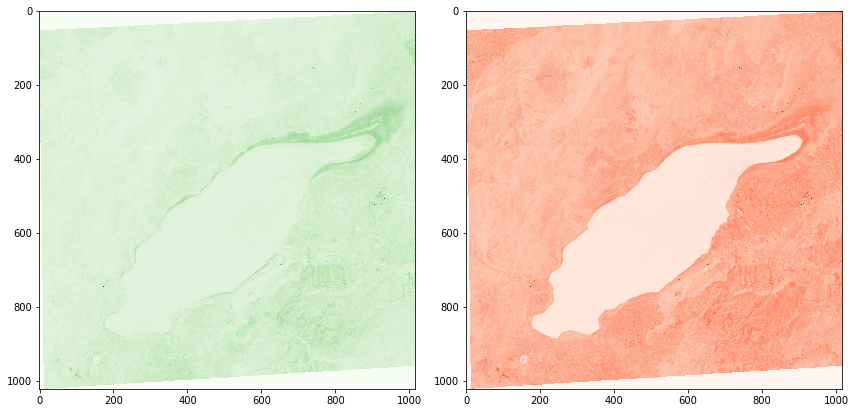

In [7]:
# Plot both bands

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot.show(crop_plot_band3, ax=ax1, cmap='Greens') #green
plot.show(crop_plot_band5, ax=ax2, cmap='Reds') #nir
fig.tight_layout()

# generate nir and green objects as arrays in float64 format
green = crop_band3.astype('float64')
nir = crop_band5.astype('float64')

In [8]:
# ndwi calculation, empty cells, nodata or negative values cells are reported as 0 to construct a mask
# NDWI = (B03 - B05) / (B03 + B05)

np.seterr(divide='ignore', invalid='ignore')

ndwi=(green.astype(float) - nir.astype(float)) / (green.astype(float) + nir.astype(float)) 

ndwi = np.nan_to_num(ndwi, nan = 0.0)
ndwi[ndwi <= 0] = 0
ndwi[ndwi > 0] = 1


In [9]:
#export ndwi image

ndwiImage = rasterio.open('ndwiImage.tiff','w',driver='Gtiff',
                          width=crop_band3.shape[1], 
                          height = crop_band3.shape[2], 
                          count=1, crs=band3.crs, 
                          transform=band3.transform, 
                          dtype='float64')
ndwiImage.write(ndwi)
ndwiImage.close()

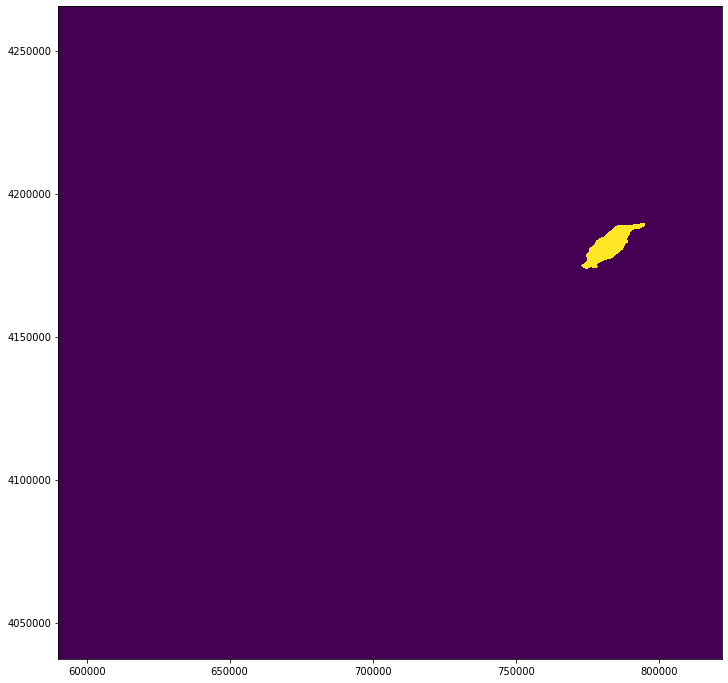

In [10]:
# plot ndwi

ndwi_file = rasterio.open('ndwiImage.tiff')
fig = plt.figure(figsize=(18,12))
plot.show(ndwi_file)

## Calculate Area from NWDI bitmap 

In [11]:
# Calculate Area from NWDI bitmap 
## This loop builds a Multipoint object with coordinates of each Lake Burdur Point.
## Need to dive deeper to see if it can be optimized

lake_ndwi_points = {"type": "MultiPoint",
                    "coordinates": []
                    }
print("Full Shape Size: {}".format(ndwi.shape))

# First and last point of the row
for i in range(0,ndwi.shape[1]):
    if np.count_nonzero( ndwi[0,i,] ) > 0:
        indexes = np.where(ndwi[0,i,] != 0)[0]
        lake_ndwi_points['coordinates'].append(band3.transform * (i, indexes[0]))
        lake_ndwi_points['coordinates'].append(band3.transform * (i, indexes[-1]))
        print("{},{}".format(i,indexes[0]), end='\r', flush=True)
        print("{},{}".format(i,indexes[-1]), end='\r', flush=True)


Full Shape Size: (1, 7731, 7601)


## Final Area calculation

In [12]:
# To calculate the area we create a shape and get the convex hull (a new object that wraps around all the lake points / perimeter ).
# Then we get the area from the convex hull and convert it to sqm

area = shape(lake_ndwi_points) #.convex_hull # .area #/1000000
print("Area: {} sqm".format(area.convex_hull.area/1000000))


Area: 478.4436 sqm


# Loop to get all images to calculate NWDI and area.
## The loop collects all images from S3, crops Lake Burdur, calculates NWDI index mask and calculates surface

## TO DO

## Below this point everything is useless ...

## Define Coordinate transformation functions